In [1]:
%load_ext tensorboard
# import tensorflow as tf
# import datetime

# # Clear any logs from previous runs
# !rm -rf ./logs/fit/

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# checkpoint_filepath = '/tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from ast import literal_eval
import pickle
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
# Postgres username, password, and database name
# POSTGRES_ADDRESS = 'localhost'

# POSTGRES_PORT = '5432'
# POSTGRES_USERNAME = 'vegas'
# POSTGRES_PASSWORD = 'VrichCrich99'
# POSTGRES_DBNAME = 'univers'

In [4]:
# postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
# cnx = create_engine(postgres_str)

In [5]:
# appstech_labs_id = 1
# df = pd.read_sql_query(f"SELECT discount_rate, discount_amount, sales_tax_rate, sales_tax_amount, exchange_rate, gross_cost, margin, gross_amount, txn_date FROM user_sales_table where appstech_labs_id='{appstech_labs_id}'", cnx, index_col='txn_date', parse_dates=['txn_date'])
# df.head()

In [6]:
# pickle.dump(df, open("sales.pkl", "wb"))

In [7]:
with open("sales.pkl", "rb") as file:
    df = pickle.load(file)
df.head()

,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,exchange_rate,gross_cost,margin,gross_amount
txn_date,,,,,,,,
2020-05-17,0.0,0.00,0.0,0.0,1.0,0.0,140.00,140.00
2020-05-19,10.0,8.75,0.0,0.0,1.0,0.0,78.75,78.75
2020-04-26,0.0,0.00,0.0,0.0,1.0,0.0,225.00,225.00
2020-05-16,0.0,0.00,0.0,0.0,1.0,0.0,337.50,337.50
2020-05-19,0.0,0.00,0.0,0.0,1.0,0.0,-87.50,-87.50


## Handling missing Values

In [8]:
threshold = 0.7
df.isna().sum()

discount_rate       0
discount_amount     0
sales_tax_rate      0
sales_tax_amount    0
exchange_rate       0
gross_cost          0
margin              0
gross_amount        0
dtype: int64

In [9]:
df = df[df.columns[df.isna().mean() < threshold]]
df = df.loc[df.isna().mean(axis=1) < threshold]

In [10]:
df.tail()

,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,exchange_rate,gross_cost,margin,gross_amount
txn_date,,,,,,,,
2020-05-18,0.0,0.0,0.0,0.0,1.0,0.00,103.55,103.55
2020-05-07,10.0,30.5,0.0,0.0,1.0,136.25,138.25,274.50
2020-05-19,0.0,0.0,0.0,0.0,1.0,0.00,375.00,375.00
2020-04-26,0.0,0.0,0.0,0.0,1.0,0.00,750.00,750.00
2020-05-04,0.0,0.0,0.0,0.0,1.0,0.00,-100.00,-100.00


In [11]:
# factor = 3

# upper_lim = df["gross_amount"].mean() + df["gross_amount"].std() * factor
# lower_lim = df["gross_amount"].mean() - df["gross_amount"].std() * factor

# print(f"upper limit {upper_lim} vs lower limit {lower_lim}")
# df = df[(df["gross_amount"] < upper_lim) & (df["gross_amount"] > lower_lim)]


upper_lim = df["gross_amount"].quantile(.95)
lower_lim = df["gross_amount"].quantile(.05)

print(f"upper limit {upper_lim} vs lower limit {lower_lim}")
df = df[(df["gross_amount"] < upper_lim) & (df["gross_amount"] > lower_lim)]

upper limit 801.1875 vs lower limit 15.625


In [12]:
# sns.pairplot(df)

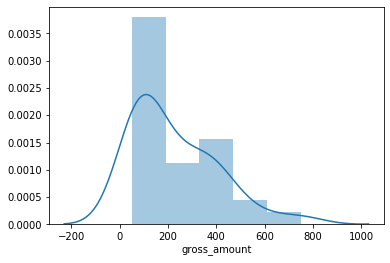

In [13]:
sns.distplot(df["gross_amount"])

In [14]:
df.head()

,discount_rate,discount_amount,sales_tax_rate,sales_tax_amount,exchange_rate,gross_cost,margin,gross_amount
txn_date,,,,,,,,
2020-05-17,0.0,0.00,0.0,0.00,1.0,0.0,140.00,140.00
2020-05-19,10.0,8.75,0.0,0.00,1.0,0.0,78.75,78.75
2020-04-26,0.0,0.00,0.0,0.00,1.0,0.0,225.00,225.00
2020-05-16,0.0,0.00,0.0,0.00,1.0,0.0,337.50,337.50
2020-05-21,0.0,0.00,8.0,26.82,1.0,135.0,200.25,335.25


In [15]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
# numeric_feats = df[numeric_feats].dtypes[df.dtypes != "datetime64[ns]"].index
# numeric_feats = df[numeric_feats].dtypes[df.dtypes != "int64"].index

imp_feats = []

cormat = df[numeric_feats].corr().fillna(0)

for feat in numeric_feats:
    try:
        if cormat[feat][-1] > 0.2:
            imp_feats.append(feat)
    except:
        pass
        

df = df[imp_feats]
df.head()

,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,
2020-05-17,0.00,0.0,140.00,140.00
2020-05-19,0.00,0.0,78.75,78.75
2020-04-26,0.00,0.0,225.00,225.00
2020-05-16,0.00,0.0,337.50,337.50
2020-05-21,26.82,135.0,200.25,335.25


In [16]:
# data = pd.DataFrame(df["gross_amount"])
# data["log+1"] = (data["gross_amount"] + 1).transform(np.log)
# data["log(x-min(x)+1)"] = (data["gross_amount"] - data["gross_amount"].min() + 1).transform(np.log)

# data["inverse_log"] = (data["log(x-min(x)+1)"]).transform(np.exp) + data["gross_amount"].min() - 1
# data

df["gross_amount"] = (df["gross_amount"] - df["gross_amount"].min() + 1).transform(np.log)
df.head()

,sales_tax_amount,gross_cost,margin,gross_amount
txn_date,,,,
2020-05-17,0.00,0.0,140.00,4.510860
2020-05-19,0.00,0.0,78.75,3.392829
2020-04-26,0.00,0.0,225.00,5.170484
2020-05-16,0.00,0.0,337.50,5.664695
2020-05-21,26.82,135.0,200.25,5.656866


In [17]:
_scaler = MinMaxScaler()

df["gross_amount"] = _scaler.fit_transform(df["gross_amount"].values.reshape(-1, 1))


In [18]:
# df = df.resample("D")[df.columns].sum()
# df = df[df["gross_amount"] > 0.0]

In [19]:
df.shape

(32, 4)

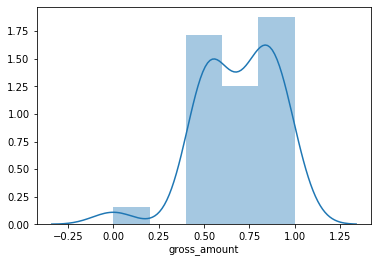

In [20]:
sns.distplot(df["gross_amount"])

In [21]:
def split_sequence(data, look_back):
    x, y = list(), list()
    
    for i in range(len(data)):
        end = i + look_back
        
        if end > len(data):
            break
        
        seq_x = data[i: end, :-1]
        seq_y = data[end-1, -1]
        
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x), np.array(y).reshape(-1, 1)


In [22]:
x, y = split_sequence(df.values, 1)

In [23]:
print(f"{x.shape} {y.shape}")

(32, 1, 3) (32, 1)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

In [25]:
y_test

array([[0.5240722 ],
       [0.5240722 ],
       [0.49722894],
       [0.61031864],
       [0.82690784],
       [0.88315764],
       [1.        ]])

In [26]:
print(f"{x_train.shape} {y_train.shape} - {x_test.shape} {y_test.shape}")

(25, 1, 3) (25, 1) - (7, 1, 3) (7, 1)


In [27]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import datetime

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([1, 5, 10, 16, 32, 50, 100, 150]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,  0.5))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.0005, 0.0001]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'nadam', "rmsprop"]))
METRIC_ACCURACY = 'mean_squared_error'

log_dir ='logs/hparam_tuning/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT,  HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='mse')])
    
    
def create_model(hparams):
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(hparams[HP_NUM_UNITS], input_shape=(n_timesteps, n_features), return_sequences=True, activation='relu'))
    model.add(LSTM(hparams[HP_NUM_UNITS]))
    model.add(Dense(100))
    model.add(Dense(n_outputs))
    
    #setting the optimizer and learning rate
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "nadam":
        optimizer = tf.optimizers.Nadam(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])
    # fit network
    history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_split=0.2, verbose=1, callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir),  # log metrics
        hp.KerasCallback(log_dir, hparams),# log hparams
        
    ])
    return history.history['val_mean_squared_error'][-1]

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = create_model(hparams)
        #converting to tf scalar
        accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_DROPOUT: dropout_rate,
                    HP_OPTIMIZER: optimizer,
                    HP_LEARNING_RATE: learning_rate
                }
                
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

--- Starting trial: run-0
{'num_units': 1, 'dropout': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}
Train on 20 samples, validate on 5 samples
Epoch 1/100
20/20 [==============================] - 9s 429ms/sample - loss: 0.5307 - mean_squared_error: 0.5307 - mean_absolute_error: 0.6918 - mean_absolute_percentage_error: 404730.6562 - cosine_proximity: 0.8500 - val_loss: 0.4154 - val_mean_squared_error: 0.4154 - val_mean_absolute_error: 0.6333 - val_mean_absolute_percentage_error: 97.8558 - val_cosine_proximity: 1.0000
Epoch 2/100
20/20 [==============================] - 0s 9ms/sample - loss: 0.5126 - mean_squared_error: 0.5126 - mean_absolute_error: 0.6791 - mean_absolute_percentage_error: 735915.1250 - cosine_proximity: 0.9500 - val_loss: 0.3985 - val_mean_squared_error: 0.3985 - val_mean_absolute_error: 0.6199 - val_mean_absolute_percentage_error: 95.6968 - val_cosine_proximity: 1.0000
Epoch 3/100
20/20 [==============================] - 0s 12ms/sample - loss: 0.4947 - mean_square

In [ ]:
%tensorboard --logdir logs/hparam_tuning